In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['STHeiti']
mpl.rcParams['font.serif'] = ['STHeiti']
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['STHeiti', 'STHeiti']})
# Set Default Encoding
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics

# 概述
尝试一下 KMeans 分类基金，利用基金的特征进行分类。KMeans 原理如下：  
1. 随机选择K个点作为聚类中心
2. 计算剩余点与中心距离，归入最近的簇
3. 对每个簇计算所有点的均值作为新的聚类中心
4. 重复2、3直至聚类中心不变

根据基金的特征利用 KMeans 算法将同一类基金聚类，首先需要根据基金的数据得到基金的特征，也就是特征工程。至于选取哪些特征，这是需要探讨的问题，这里先简单进行尝试。

# 特征选取
## 读取数据
▍读取fund_performance数据和涨跌幅数据

In [2]:
# fund performance
fp = pd.read_csv('data/fund_performance.csv',dtype={'code':str})
fp.set_index('code',inplace=True)
# NAV data
nav = pd.read_csv('data/two_years_data.csv')
nav['date'] = pd.to_datetime(nav['date'])
nav.set_index('date',inplace=True)

## 数据预处理
▍将涨跌幅数据转换为涨跌的等级  
共分为七个级别，采用quantile函数划分。即按照涨跌幅排在整体分布中的位置划分，划分为 0~0.1、0.1~0.2等七个级别。

In [3]:
rate_range = []
for p in [0.0,0.1,0.2,0.4,0.6,0.8,0.9,1.0]:
    rate_range.append(nav.unstack().quantile(p))
# 
rate_level = nav.apply(lambda x: pd.cut(x,rate_range,labels=np.arange(7)))

▍计算每个基金每个等级所含的数量

In [4]:
def calLevel(x):
    level_nums = []
    for level in np.arange(7):
        level_nums.append((x==level).sum())
    return level_nums
#
level = rate_level.apply(lambda x: calLevel(x))
#pd.DataFrame.from_items(zip(df_level.index, df_level.values))
df_level = level.apply(lambda x: pd.Series(x))

▍合并 level 和 fund_performance

In [5]:
feature = pd.merge(df_level,fp,how='left',right_index=True,left_index=True)
feature.rename(index=str, columns={0: "level_0", 1: "level_1", 2: "level_2",
                                   3: "level_3", 4: "level_4", 5: "level_5",
                                   6: "level_6"},inplace=True)
feature.head()

,level_0,level_1,level_2,level_3,level_4,level_5,level_6,return,beta,alpha,r_squared,std,up_days,max_rate,min_rate
000001,51,69,100,27,97,59,43,-0.046535,1.197893,-0.070828,92.254118,1.001862,226,2.89,-6.27
000011,57,71,69,18,101,68,62,0.079641,1.532346,0.056941,86.012987,1.327264,249,5.12,-8.16
000017,64,77,77,15,77,64,72,-0.056323,1.497941,-0.079187,86.969193,1.290311,228,4.44,-7.73
000020,66,64,72,11,88,67,78,0.122270,1.657785,0.100167,91.334419,1.393457,244,5.27,-8.17
000021,63,77,80,17,77,73,59,-0.032180,1.686314,-0.054146,96.567434,1.378497,226,4.76,-8.14


利用上表的特征，将基金分类。
# KMeans 分类
##  数据标准化
▍先将数据标准化，采用最小最大值标准化。

In [6]:
#f_scaler = feature.drop(['std','max_rate','min_rate','level_3','alpha'],axis=1)
f_scaler = feature.apply(preprocessing.minmax_scale)

## K 值确定
### 肘部法
KMeans 是使得 SSE (Sum of Squared Error) 达到最小，目标函数 SSE 表示如下：  
$SSE(C_1,C_2,\cdots,C_m)=\sum\limits_{i=1}^{m}(x-c_i)^2,$  
即 SSE 越小，各类的聚拢效果越佳。

**肘部法**：计算 SSE 随 K 值的变化，K 值增大过程中，SSE 下降幅度最大的位置对应的 K 值就是肘部，也就是 SSE 随 K 值转弯的地方。
### 轮廓系数
轮廓系数（Silhouette Coefficient）结合了聚类的凝聚度（Cohesion）和分离度（Separation），用于评估聚类的效果。该值处于-1~1之间，值越大，表示聚类效果越好。它会随着类的规模增大而增大。彼此相距很远，本身很密集的类，其轮廓系数较大，彼此集中，本身分布很大的类，其轮廓系数较小。其计算方法如下：  
* 簇内不相似度 ($a_i$)：样本 i 到同簇其他样本的平均距离；
* 簇间不相似度 ($b_i$)：样本i到其他簇所有样本的平均距离；
* 样本 i 的轮廓系数为：  
$s(i)=\frac{b_i-a_i}{\max(a_i,b_i)}$

所有样本结果的均值为聚类结果的轮廓系数。

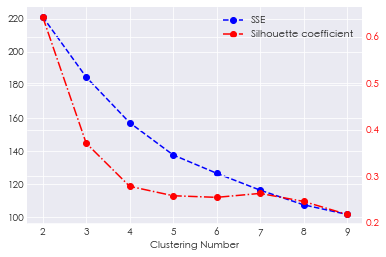

In [7]:
data = f_scaler.values
ns = np.arange(2,10)
silhouette_score = []
sse = []
for n in ns:
    km = KMeans(n_clusters=n)
    label = km.fit_predict(data)
    silhouette_score.append(metrics.silhouette_score(data,label,metric='euclidean'))
    sse.append(km.inertia_)
#
fig, host = plt.subplots()
l1, = host.plot(ns, sse, 'b--',marker='o')
host.set_xlabel('Clustering Number')
#
ax2 = host.twinx()
l2, = ax2.plot(ns, silhouette_score, 'r-.',marker='o')
ax2.tick_params('y', colors='r')
lines = [l1,l2]
host.legend(lines,[u'SSE', u'Silhouette coefficient'])

根据上述方法，并不能很好的确定 K 值，这可能是因为数据分离性较差造成的。

## 分类结果
### 初步结果
考虑到 3 类的轮廓系数较大且 SSE 相对较小，暂定将基金分为 3类。

In [8]:
km = KMeans(n_clusters=3)
label = km.fit_predict(data)
feature['label'] = label

▍分类结果可视化 

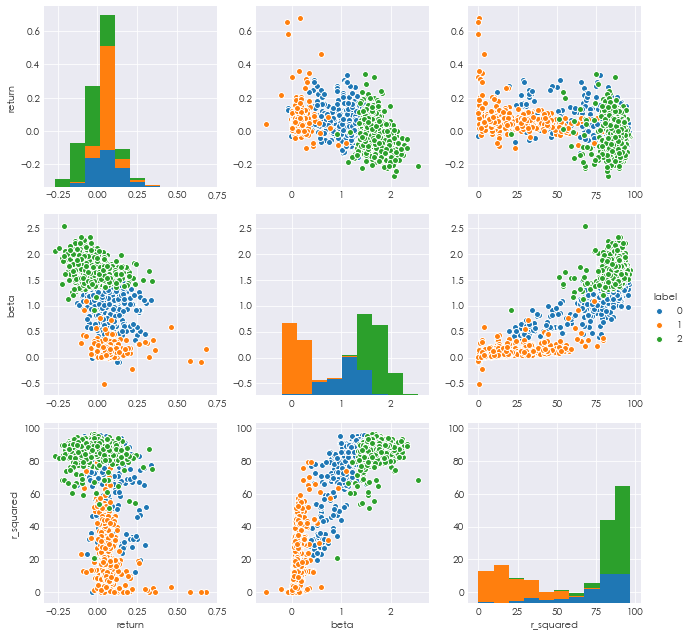

In [9]:
sns.pairplot(vars=['return','beta','r_squared'],data=feature,hue='label',size=3)

我们希望主要按照收益将数据分类，但实际结果是 beta 和 r_squared 的分离度较好。这可能是因为 bate 和 r_squared 具有较好的离散度，能够被很好的分类。利用上述的特征，KMenas 没有很好地将基金分类。

### 初步结果 (续)
将所有特征离散化为 10 个等级，重新进行分类。

In [10]:
def dis_ten(fea):
    """fea: Series"""
    fea_range = [fea.quantile(x) for x in np.arange(11)/10.]
    # the bins not include the leftmost edge
    fea_range[0] = fea_range[0] - 0.1
    fea_range = set(fea_range)
    fea_range = np.sort(list(fea_range))
    return pd.cut(fea,fea_range,labels=np.arange(len(fea_range)-1))
f_scaler = feature.apply(lambda x: dis_ten(x))

▍重复上述过程

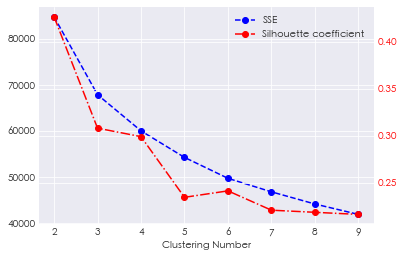

In [11]:
data = f_scaler.values
ns = np.arange(2,10)
silhouette_score = []
sse = []
for n in ns:
    km = KMeans(n_clusters=n)
    label = km.fit_predict(data)
    silhouette_score.append(metrics.silhouette_score(data,label,metric='euclidean'))
    sse.append(km.inertia_)
#
fig, host = plt.subplots()
l1, = host.plot(ns, sse, 'b--',marker='o')
host.set_xlabel('Clustering Number')
#
ax2 = host.twinx()
l2, = ax2.plot(ns, silhouette_score, 'r-.',marker='o')
ax2.tick_params('y', colors='r')
lines = [l1,l2]
host.legend(lines,[u'SSE', u'Silhouette coefficient'])

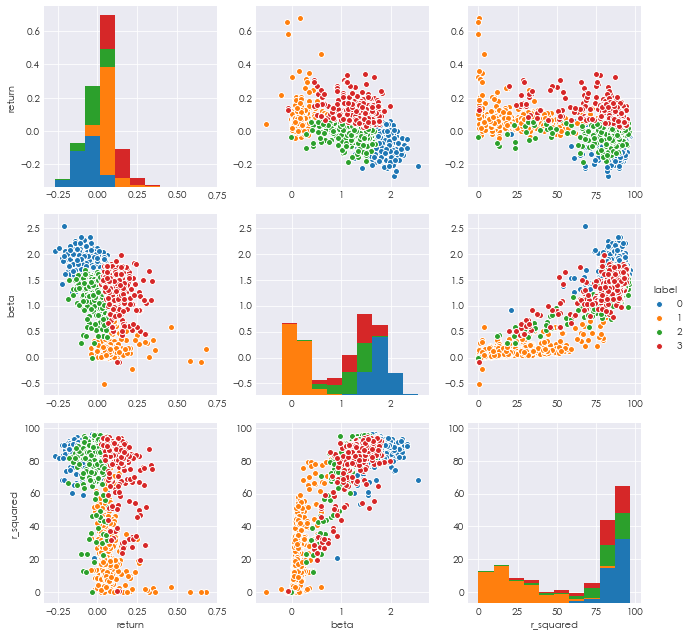

In [12]:
km = KMeans(n_clusters=4)
label = km.fit_predict(data)
feature['label'] = label
sns.pairplot(vars=['return','beta','r_squared'],data=feature,hue='label',size=3)

从图中，label == 3 的是好基金，其收益高，beta 接近 1 ，r_squared 接近与 100。

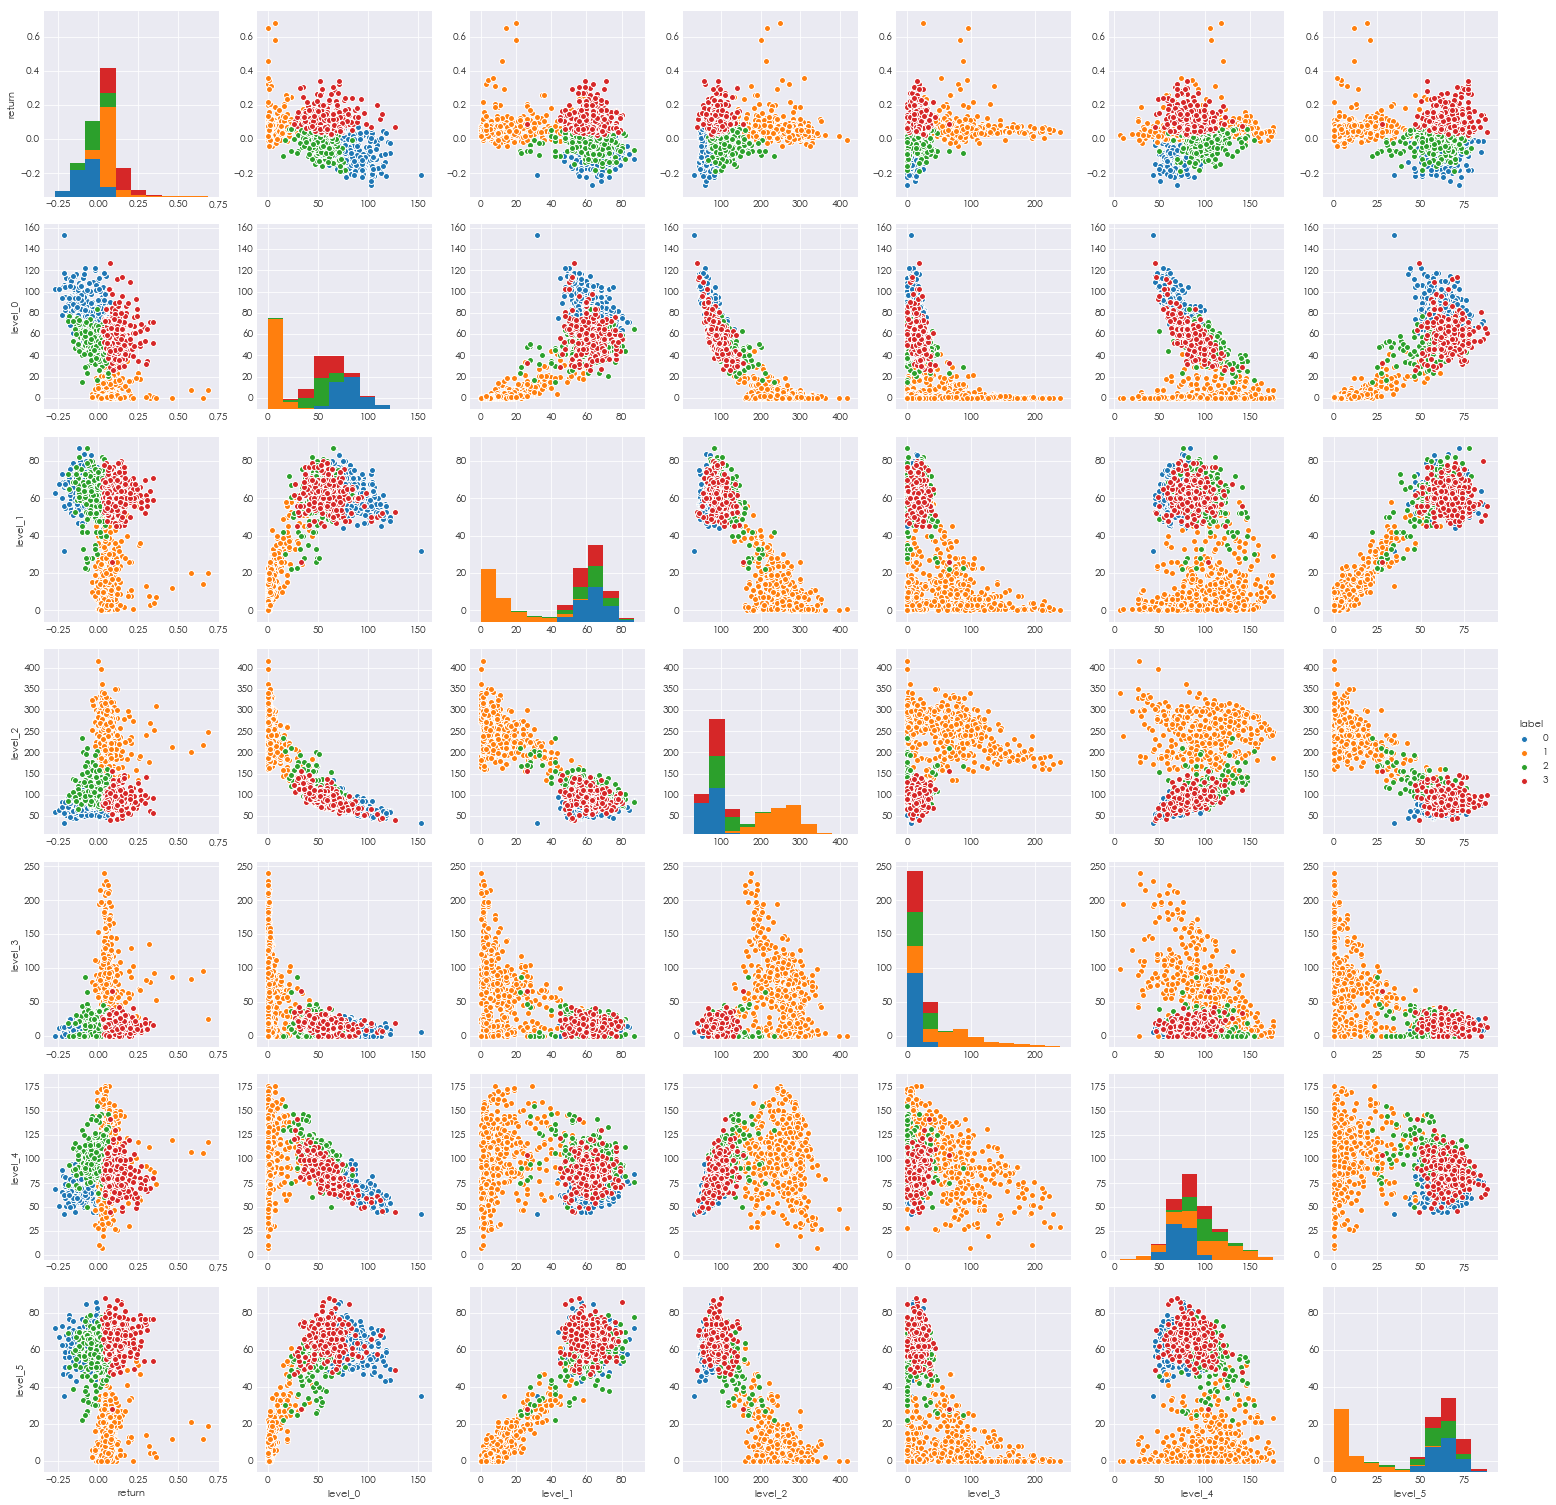

In [13]:
sns.pairplot(vars=['return','level_0','level_1','level_2','level_3','level_4','level_5'],data=feature,hue='label',size=3)

level == 3 的类，level_5 的数量也较多。